# Goals

  * sentiment analysis on twitter thread interactions.
  * train a model to be able to predict conversation sentiment.

      * based on the first tweet?
      * proactive measures for dealing with customers.

# Note to self

* find a different way to download
* figure out best order... to pre-process
* stopwatches 
* figure out best way to split up the data 
* train test split for both models 
  
  * pick the best to use for project

In [1]:
!pip install -q kaggle
from google.colab import files 
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d thoughtvector/customer-support-on-twitter


Saving kaggle.json to kaggle.json
 98% 165M/169M [00:02<00:00, 91.3MB/s]
100% 169M/169M [00:02<00:00, 76.1MB/s]


In [2]:
!pip install cloudmesh-installer
!pip install cloudmesh-common 

     |████████████████████████████████| 81kB 4.5MB/s 
     |████████████████████████████████| 81kB 5.6MB/s 
     |████████████████████████████████| 133kB 13.5MB/s 
     |████████████████████████████████| 870kB 14.2MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
  Created wheel for ordered-set: filename=ordered_set-4.0.2-py2.py3-none-any.whl size=8210 sha256=495098bc0e469ba30362a28d0cba1ab563409de462af32cf3aa646a5b4b7472c
  Stored in directory: /root/.cache/pip/wheels/e1/c6/9b/651d8a21d59b51a75ab9c070838f9231b8126421bc0569af47
  Created wheel for python-hostlist: filename=python_hostlist-1.21-cp37-none-any.whl size=38931 sha256=9142683f853160a70b7580bd00acc61edfa30295b09af53d29de0145e59ee19c
  Stored in directory: /root/.cache/pip/wheels/0b/5b/55/ddcf52288f0b10f4564ca1b2531594ff7ccc65f487ba8dc437
Successfully built ordered-set python-hostlist
ERROR: pytest-cov 2.11.1 has requirement coverage>=5.2.1, but you'll have covera

In [70]:
from __future__ import absolute_import 
from __future__ import division
from __future__ import print_function

import time
from cloudmesh.common.StopWatch import StopWatch
from cloudmesh.common.Benchmark import Benchmark
from cloudmesh.common.Shell import Shell

import zipfile 

#dealing with data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

#nl libraries
import string 
import nltk #natural language tool kit
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [71]:
StopWatch.start("get_data")

zfile=zipfile.ZipFile('/content/customer-support-on-twitter.zip')
data=pd.read_csv(zfile.open('twcs/twcs.csv')) 
StopWatch.stop("get_data")

data.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [72]:
data.shape

(2811774, 7)

In [73]:
StopWatch.start("manageability")

df=data.drop(['inbound','created_at'],axis=1)
df["text"]=df["text"].astype(str)
df.sample(frac=1)
df=df.head(20000) #for easier management i imagine its going to take a long time if we dont cut it down

StopWatch.stop("manageability")

In [74]:
StopWatch.start("sentiment_score")

sent_analyzer=SentimentIntensityAnalyzer()
#note to self if we dont cut down data then this takes about 13 minutes for refernece
df["sentiment"]=df["text"].apply(lambda x: sent_analyzer.polarity_scores(x)["compound"])

StopWatch.stop("sentiment_score")

In [75]:
# id_group=df.groupby('author_id') 
# sent_avg_author=id_group.sentiment.mean().sort_values()
# sentiment_by_author=pd.DataFrame({'author_id':sent_avg_author.index, 'sentiment':sent_avg_author.values})

# fig, axs=plt.subplots(2,1, sharey=False, tight_layout=True, sharex=True)

# axs[0].hist(df["sentiment"])
# axs[0].set_title("Tweet Sentiment Distribution")
# axs[1].hist(sentiment_by_author["sentiment"])
# axs[1].set_title("Author Sentiment Distribution")

# fig.savefig("sentiment_dist.png")
# fig.show()

# sentiment_by_author.head() #show the dataframe 

In [76]:
StopWatch.start("removing_companies")

def companies(df):
  idx=[]
  for id in range(len(df["author_id"])):
      vowels=['a','e','i','o', 'u']
      for vowel in vowels:
        if vowel in df["author_id"][id]:
          idx.append(id)
          break 
  return df.drop(idx)

customer_df=companies(df)

StopWatch.stop("removing_companies")


print(df.shape)
print(customer_df.shape)

(20000, 6)
(11159, 6)


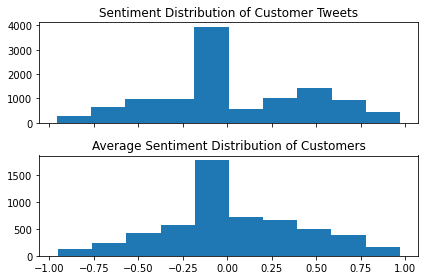

In [78]:

customer_group=customer_df.groupby('author_id') 
sent_avg_customer=customer_group.sentiment.mean().sort_values()
sentiment_by_customer=pd.DataFrame({'author_id':sent_avg_customer.index, 'sentiment':sent_avg_customer.values})

fig, axs=plt.subplots(2,1, sharey=False, tight_layout=True, sharex=True)

axs[0].hist(customer_df["sentiment"])
axs[0].set_title("Sentiment Distribution of Customer Tweets")
axs[1].hist(sentiment_by_customer["sentiment"])
axs[1].set_title("Average Sentiment Distribution of Customers")

fig.savefig("customer_dist.png")
fig.show()



# Cnn model 

In [80]:
#Cnn libraries 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten, AveragePooling1D
from tensorflow.keras.utils import to_categorical, plot_model

# Building the model

In [81]:
batch_size=128
kernel_size=3
pool_size=2
filters=64
dropout=0.2

#TODO
input_shape=(10,1) #figure this out
num_labels=10 #idk what to do

StopWatch.start("cnn_model_building")

cnn_model=Sequential()

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(MaxPooling1D(pool_size))

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(MaxPooling1D(pool_size))

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(MaxPooling1D(pool_size))

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dropout(dropout))
cnn_model.add(Dense(num_labels))
cnn_model.add(Activation('softmax'))
cnn_model.summary()
plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True)

StopWatch.stop("cnn_model_building")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 64)             12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 64)             1

# Compile 

In [82]:
StopWatch.start("cnn_compile")
cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
StopWatch.stop("cnn_compile")

# Model Fit

In [ ]:
StopWatch.start("cnn_train")
cnn_model.fit(train_text, train_sentiment, epochs, batch_size=batch_size)
StopWatch.stop("cnn_train")

NameError: ignored

# Evaluate

In [ ]:
StopWatch.start("cnn_evaluate")
cnn_loss, cnn_accuracy=cnn_model.evaluate(test_text, test_sentiment, batch_size = batch_size)
print("CNN Accuracy: %.1f%%" %(100.0*cnn_accuracy))
StopWatch.stop("cnn_evaluate")

# Rnn model

In [83]:
#rnn libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, SimpleRNN
from tensorflow.keras.utils import to_categorical, plot_model

# Building the model

In [84]:
batch_size=128
units=256
dropout=0.2

input_shape=(10,1) #figure this out
num_labels=10

StopWatch.start("rnn_model_building")
rnn_model=Sequential()
rnn_model.add(SimpleRNN(units=units, dropout=dropout,
                         input_shape=input_shape, return_sequences=True))
rnn_model.add(SimpleRNN(units=units, dropout=dropout,
                         input_shape=input_shape, return_sequences=True))
rnn_model.add(SimpleRNN(units=units, dropout=dropout,
                         input_shape=input_shape, return_sequences=True))
rnn_model.add(Dense(num_labels))
rnn_model.add(Activation('softmax'))
rnn_model.summary()
plot_model(rnn_model, to_file='rnn_model.png', show_shapes=True)
StopWatch.stop("rnn_model_building")


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10, 256)           66048     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10, 256)           131328    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10, 256)           131328    
_________________________________________________________________
dense_1 (Dense)              (None, 10, 10)            2570      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 10)            0         
Total params: 331,274
Trainable params: 331,274
Non-trainable params: 0
_________________________________________________________________


# Compile

In [85]:
StopWatch.start("rnn_compile")
rnn_model.compile(loss='categorical_crossentropy', 
                  optimizer='sgd', metrics=['accuracy'])
StopWatch.stop("rnn_compile")

# Model Fit

In [ ]:
StopWatch.start("rnn_train")
rnn_model.fit(train_text, train_sentiment, epochs, batch_size=batch_size)
StopWatch.stop("rnn_train")

# Evaluation

In [ ]:
StopWatch.start("rnn_evaluate")
rnn_loss, cnn_accuracy=cnn_model.evaluate(test_text, test_sentiment, batch_size = batch_size)
print("RNN Accuracy: %.1f%%" %(100.0*rnn_accuracy))
StopWatch.stop("rnn_evaluate")